In [1]:
import os

os.environ["BRASA_DATA_PATH"] = "D:\\brasa"

In [2]:
import sys
sys.path.append('..')

from datetime import datetime

import numpy as np
import pandas as pd
import pyarrow.dataset as ds
import pyarrow.compute as pc
import pyarrow

import brasa

man = brasa.engine.CacheManager()

In [3]:
from bizdays import Calendar, set_option

set_option("mode", "pandas")
cal = Calendar.load("B3")

In [5]:
symbols = brasa.get_dataset("b3-listed-funds").filter(pc.field("fund_type") == "ETF").scanner(columns=["symbol"]).to_table().to_pandas().iloc[:,0]

In [7]:
ds_cotahist = brasa.get_dataset("b3-cotahist")
# df_cotahist = ds_cotahist\
#         .filter(pc.field("refdate") >= cal.startdate)\
#         .filter(pc.field("instrument_market") == 10)\
#         .filter(pc.field("bdi_code") == 14)\
#         .filter(pc.is_in(pc.utf8_slice_codeunits(pc.field("isin"), 6, 9), pyarrow.array(["CTF"])))\
#         .filter(pc.starts_with(pc.field("specification_code"), "CI"))\
#         .scanner(columns=["refdate", "symbol", "close"])\
#         .to_table()\
#         .to_pandas()
df_cotahist = ds_cotahist\
        .filter(pc.field("refdate") >= cal.startdate)\
        .filter(pc.field("symbol").isin(symbols))\
        .scanner(columns=["refdate", "symbol", "close"])\
        .to_table()\
        .to_pandas()
df_cotahist

,refdate,symbol,close
0,2004-08-03,PIBB11,27.75
1,2004-08-02,PIBB11,27.75
2,2004-07-30,PIBB11,27.70
3,2004-07-29,PIBB11,27.59
4,2004-07-28,PIBB11,27.45
...,...,...,...
77637,2008-01-03,PIBB11,95.81
77638,2008-01-04,PIBB11,93.70
77639,2008-01-07,PIBB11,93.00
77640,2008-01-08,PIBB11,94.00


In [23]:
# etf_cotahist_prices = df_cotahist.pivot_table(values="close", index="refdate", columns="symbol")
# etf_cotahist_prices
# idx = cal.seq(etf_cotahist_prices.index[0], etf_cotahist_prices.index[-1])
# etf_cotahist_prices = etf_cotahist_prices.reindex(idx)
# etf_cotahist_pct_change = etf_cotahist_prices.pct_change()
# etf_cotahist_pct_change

def calc_pct_change(df):
    dfi = df[["refdate", "close"]].set_index("refdate").sort_index()
    idx = cal.seq(dfi.index[0], dfi.index[-1])
    dfi = dfi.reindex(idx)
    dfi.index.name = "refdate"
    dfi = dfi.pct_change(fill_method=None).iloc[1:]
    dfi.columns = ["pct_return"]
    dfi["log_return"] = np.log(1 + dfi["pct_return"])
    return dfi

df_cotahist_etfs_returns = df_cotahist.groupby("symbol").apply(calc_pct_change).reset_index()
ix = df_cotahist_etfs_returns["refdate"] < datetime(2018, 1, 1)
df_cotahist_etfs_returns[ix]

,symbol,refdate,pct_return,log_return
3187,BBSD11,2014-12-01,-0.035376,-0.036017
3188,BBSD11,2014-12-02,0.030217,0.029769
3189,BBSD11,2014-12-03,NaN,NaN
3190,BBSD11,2014-12-04,NaN,NaN
3191,BBSD11,2014-12-05,0.004630,0.004619
...,...,...,...,...
76220,XBOV11,2017-12-21,0.024269,0.023979
76221,XBOV11,2017-12-22,0.000808,0.000807
76222,XBOV11,2017-12-26,-0.001480,-0.001481
76223,XBOV11,2017-12-27,0.000000,0.000000


<Axes: >

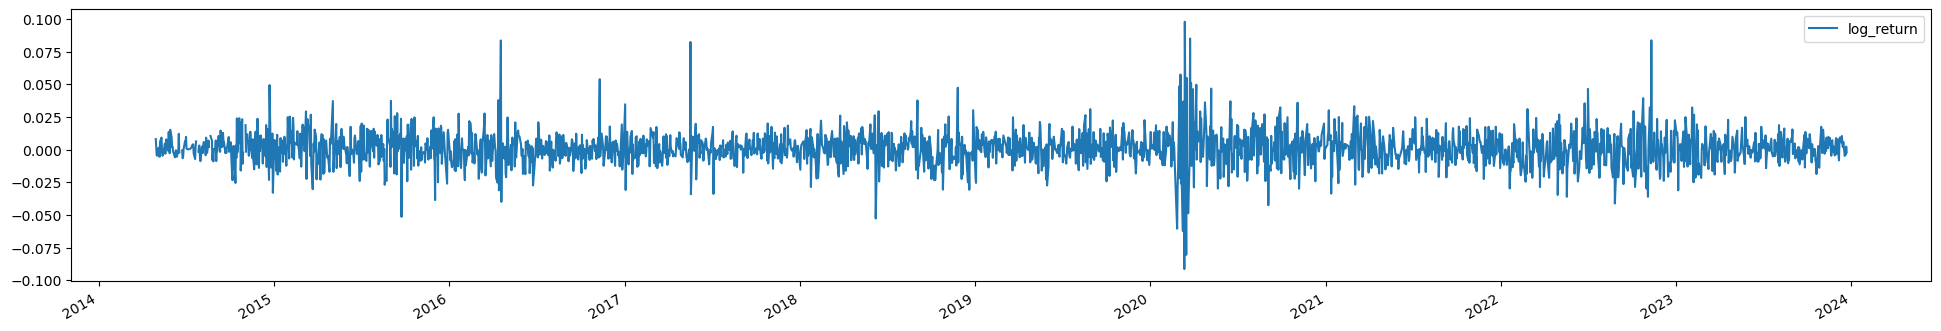

In [27]:
dfi = df_cotahist_etfs_returns.query("symbol == 'IVVB11'")[["refdate", "log_return"]].set_index("refdate")
idx = cal.seq(dfi.index[0], dfi.index[-1])
dfi = dfi.reindex(idx)
dfi.plot(figsize=(24, 4))

In [36]:
ds_eq_sm = brasa.get_dataset("b3-equities-spot-market")
ds_md = brasa.get_dataset("b3-bvbg086")
# symbols = ds_eq_sm\
#     .filter(pc.field("instrument_market") == 10)\
#     .filter(pc.field("security_category") == 3)\
#     .filter(pc.is_in(pc.utf8_slice_codeunits(pc.field("isin"), 6, 9), pyarrow.array(["CTF"])))\
#     .filter(pc.starts_with(pc.field("specification_code"), "CI"))\
#     .scanner(columns=["symbol"])\
#     .to_table()\
#     .column("symbol")\
#     .unique()
symbols = etfs["symbol"]
df_bvbg = ds_md\
    .filter(pc.field("symbol").isin(symbols))\
    .scanner(columns=["refdate", "symbol", "close"])\
    .to_table()\
    .to_pandas()
df_bvbg

,refdate,symbol,close
0,2018-01-02,IVVB11,92.12
1,2018-01-02,SMAL11,81.50
2,2018-01-02,BOVV11,78.10
3,2018-01-02,XBOV11,77.00
4,2018-01-02,GOVE11,32.88
...,...,...,...
56885,2023-12-22,MILL11,50.72
56886,2023-12-22,GOLD11,10.53
56887,2023-12-22,ISUS11,37.50
56888,2023-12-22,SCVB11,97.05


In [37]:
# df_cotahist_bvbg = df_cotahist.join(df_bvbg, on=["refdate", "symbol"], how="outer")
# df_cotahist_bvbg
df_cotahist_bvbg = pd.merge(df_cotahist, df_bvbg, on=["refdate", "symbol"], how="outer", suffixes=("_cotahist", "_bvbg"))
fill_bvbg = df_cotahist_bvbg["close_bvbg"].isna() & ~df_cotahist_bvbg["close_cotahist"].isna()
df_cotahist_bvbg["close"] = df_cotahist_bvbg["close_bvbg"]
df_cotahist_bvbg.loc[fill_bvbg, "close"] = df_cotahist_bvbg.loc[fill_bvbg, "close_cotahist"]
# df_etf_cotahist.loc[ix_cotahist, "close"] = df_etf_cotahist.loc[ix_cotahist, "close_bvbg"]
df_cotahist_bvbg

,refdate,symbol,close_cotahist,close_bvbg,close
0,2004-08-03,PIBB11,27.75,NaN,27.75
1,2004-08-02,PIBB11,27.75,NaN,27.75
2,2004-07-30,PIBB11,27.70,NaN,27.70
3,2004-07-29,PIBB11,27.59,NaN,27.59
4,2004-07-28,PIBB11,27.45,NaN,27.45
...,...,...,...,...,...
77942,2023-09-25,ECOO11,NaN,NaN,NaN
77943,2023-10-05,ECOO11,NaN,NaN,NaN
77944,2023-10-20,ECOO11,NaN,NaN,NaN
77945,2023-10-25,ECOO11,NaN,NaN,NaN


In [38]:
ix = df_cotahist["refdate"] < datetime(2018, 1, 1)
df_etf = pd.concat([df_cotahist.loc[ix], df_bvbg])

In [39]:
# etf_prices = df_cotahist_bvbg.pivot_table(values="close", index="refdate", columns="symbol")
etf_prices = df_etf.pivot_table(values="close", index="refdate", columns="symbol")
etf_prices

symbol,5GTK11,ACWI11,AGRI11,ALUG11,BBOI11,BBOV11,BBSD11,BCIC11,BDEF11,BDOM11,...,URET11,USAL11,USTK11,UTEC11,WEB311,WRLD11,XBOV11,XFIX11,XINA11,YDRO11
refdate,,,,,,,,,,,,,,,,,,,,,
2004-07-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-07-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-07-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-07-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-07-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-18,81.80,10.24,50.53,34.82,7.60,67.85,107.10,123.05,122.24,113.27,...,8.84,9.83,10.70,14.04,25.60,87.42,128.35,11.35,4.98,36.13
2023-12-19,81.66,10.22,51.05,34.79,7.55,68.46,107.16,123.97,123.52,113.89,...,8.84,9.82,10.62,14.00,25.30,87.84,129.08,11.40,5.00,36.47
2023-12-20,81.01,10.20,51.05,34.72,7.60,67.63,107.15,122.97,123.19,113.08,...,8.82,9.76,10.60,13.90,25.35,87.55,128.11,11.41,4.90,35.96


In [40]:
idx = cal.seq(etf_prices.index[0], etf_prices.index[-1])
etf_prices = etf_prices.reindex(idx)

In [50]:
etfs = ["BBOV11",
        "BOVB11",
        "IBOB11",
        "XBOV11",
        "BOVA11",
        "BOVV11",
        "BOVS11",
        "BOVX11",
        ]

<Axes: >

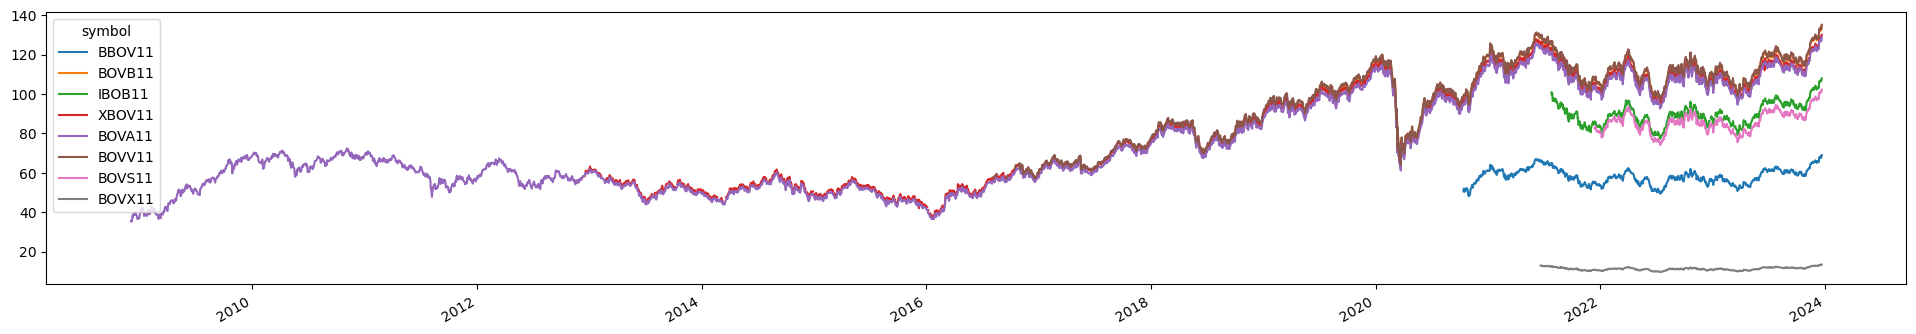

In [51]:
etf_prices.loc[:, etfs].plot(figsize=(24, 4))

<Axes: >

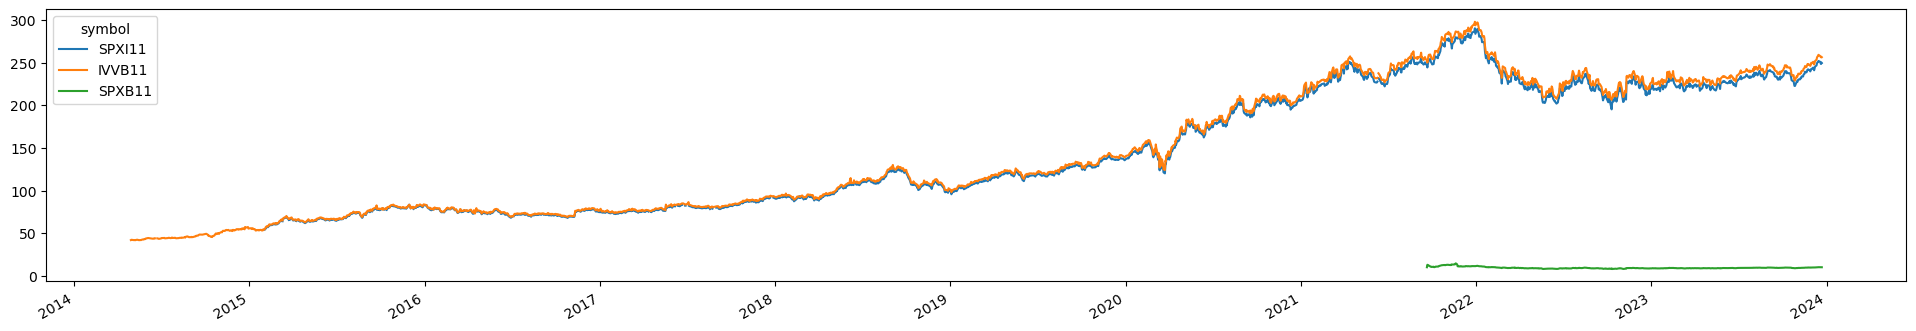

In [49]:
etf_prices.loc[:, ["SPXI11", "IVVB11", "SPXB11"]].plot(figsize=(24, 4))

<Axes: >

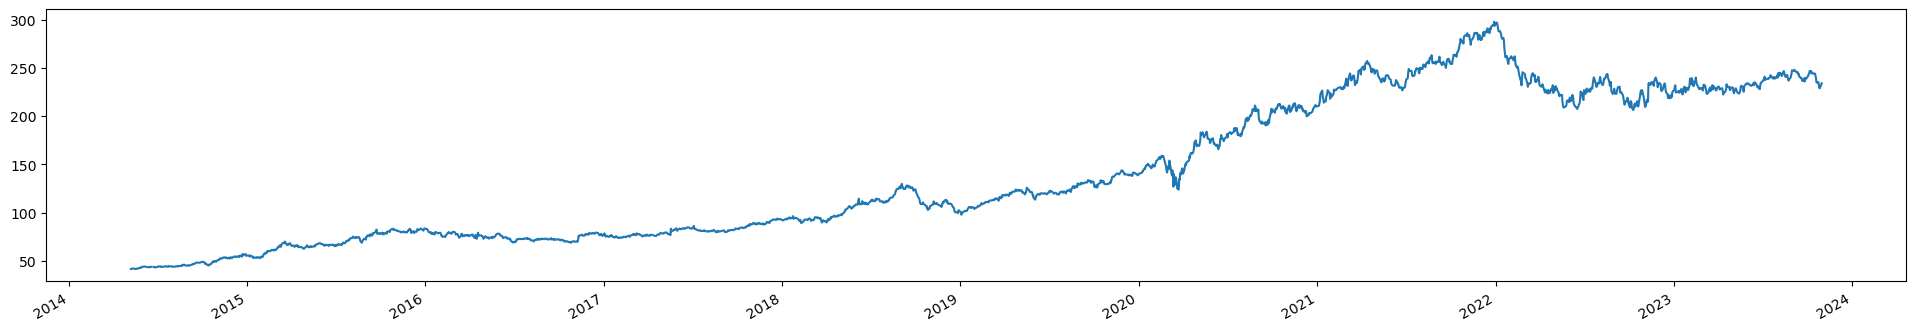

In [46]:
spxi = df_cotahist.query("symbol == 'IVVB11'")
spxi = spxi.set_index("refdate")
idx = cal.seq(spxi.index[0], spxi.index[-1])
spxi = spxi.reindex(idx)
spxi["close"].plot(figsize=(24, 4))

<Axes: >

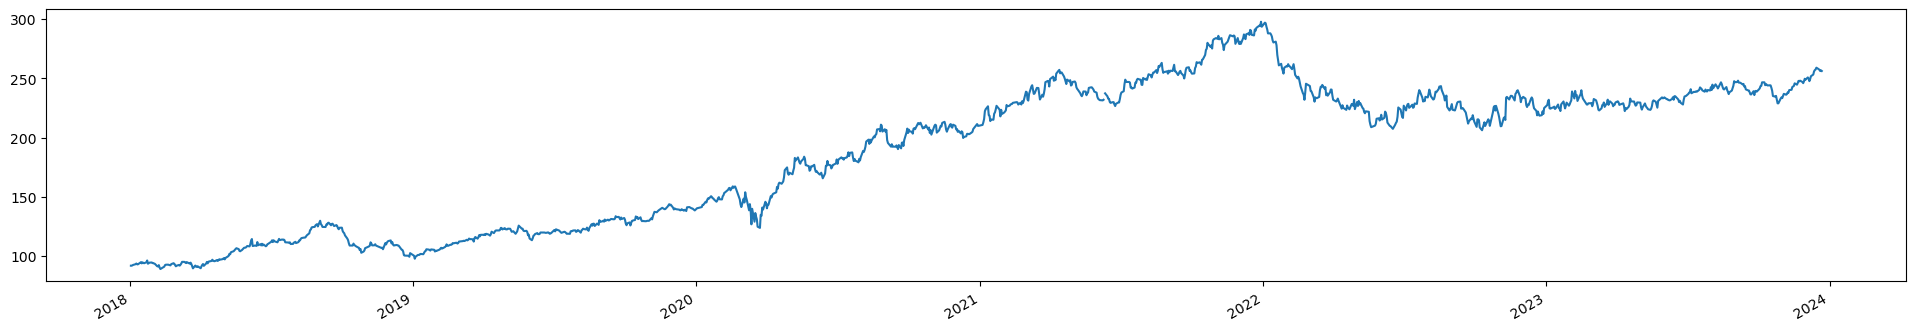

In [47]:
spxi = df_bvbg.query("symbol == 'IVVB11'")
spxi = spxi.set_index("refdate")
idx = cal.seq(spxi.index[0], spxi.index[-1])
spxi = spxi.reindex(idx)
spxi["close"].plot(figsize=(24, 4))